In [156]:
import warnings

# The workhorses
import pandas as pd
import numpy as np

# Our main MCMC package
import emcee
import collections
import scipy.stats as st

from numba import jit

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.patches

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
# Load data
df = pd.read_csv('data/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)

In [34]:
wt = df[df['genotype']=='wt']['mean_rest_bout_length']
mut = df[df['genotype']=='mut']['mean_rest_bout_length']

## Problem 5.1a Frequentist parameter estimation

We are assuming that both the wild-type and mutant bout-lengths have Gaussian distributions and want unbiased estimators for $\mu_i$ and $\sigma_i^2$, where $i \in \{w,m\}$. These are, respectively, the sample mean:
$$\bar{x_i} = \frac{1}{n_i}\sum_{x_j \in i} x_j$$
and the sample variance:
$$s_i^ 2 = \frac{1}{n_i-1}\sum_{x_j \in i} (x_j - \bar{x_i})^ 2$$

We will use the built-in functions in Pandas to calculate these. 

In [94]:
x_bar_w = wt.mean()
x_bar_m = mut.mean()
var_w = wt.var(ddof=1)
var_m = mut.var(ddof=1)
n_wt = len(wt)
n_mut = len(mut)
print ('            mean (min)   variance (min²)    n')
print ('wild-type:  %.3f        %.3f             %d' %(x_bar_w, var_w, n_wt))
print ('mutant:     %.3f        %.3f             %d' %(x_bar_m, var_m, n_mut))

            mean (min)   variance (min²)    n
wild-type:  2.209        0.273             17
mutant:     1.727        0.648             22


We also want to calculate Cohen's d as an estimate of the effect size. 

In [36]:
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = y.mean() - x.mean()
    pooled_variance = (len(x) * x.var() + len(y) * y.var()) / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)

actual_d = cohen_d (wt,mut)

print ("Cohen's d = %.4f" %actual_d)

Cohen's d = -0.6927


## Problem 5.1b Frequentist estimation of the difference

Let's do this by bootstrapping. First, let's make a function that draws bootstrap samples and uses them to estimate some parameter. 

In [37]:
def bootstrap_estimate (x, n, param_fun, args=(), replicates=1000):
    """Estimates a parameter by drawing bootstrap samples of x. """
    return np.array([param_fun(np.random.choice(x, n, replace=True)) \
            for r in range(replicates)])

Now, let's use this function to calculate $\delta = \bar{x_w} - \bar{x_m}$ for 1000 bootstrap samples. 

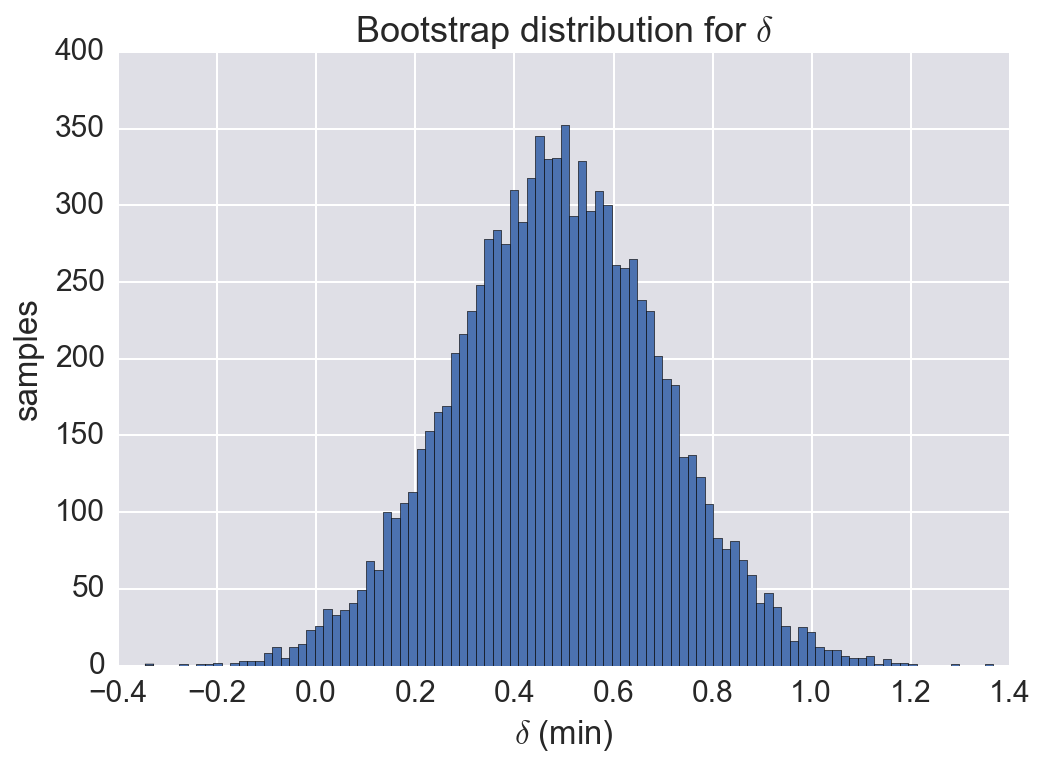

In [38]:
deltas = bootstrap_estimate (wt, n_wt, np.mean, replicates=10000) \
- bootstrap_estimate(mut, n_mut, np.mean, replicates=10000)
_ = plt.hist(deltas, bins=100)
plt.xlabel ('$\delta$ (min)')
plt.ylabel ('samples')
plt.title ('Bootstrap distribution for $\delta$')

That looks Gaussian enough that we can use the mean as the best estimate. We'll use the 2.5th and 97.5th percentiles to get a 95% confidence interval. 

In [39]:
delta_bar = np.mean(deltas)
CI = tuple(np.percentile (deltas, (2.5, 97.5)))
print ('The mean bootstrap value for delta is %.4f minutes.' % delta_bar)
print ('The 95%% confidence interval for delta is (%.4f,%.4f) minutes.' %CI)

The mean bootstrap value for delta is 0.4867 minutes.
The 95% confidence interval for delta is (0.0772,0.8955) minutes.


# Problem 5.1 c

In [160]:
mut_inds = df['genotype'] == 'mut'
wt_inds = df['genotype'] == 'wt'

df_mut = df[mut_inds]
df_wt = df[wt_inds]

wt_rest = df_wt['mean_rest_bout_length']
mut_rest = df_mut['mean_rest_bout_length']

In [112]:
def log_post(p, x_1, x_2):
    """
    p[0] = mu_wt
    p[1] = mu_mut
    p[2] = sigma_wt
    p[3] = sigma_mut
    """
    # Unpack parameters
    mu_wt, mu_mut, sigma_wt, sigma_mut = p
    
    # Make sure we have everything in the right range
    if (sigma_wt < 0) or (sigma_mut < 0):
        return -np.inf
    
    if (mu_wt < 0) or (mu_wt > 20):
        return -np.inf
    
    if (mu_mut < 0) or (mu_mut > 20):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_1 = st.norm.logpdf(x_1, mu_wt, sigma_wt).sum() - np.log(sigma_wt)
    log_post_2 = st.norm.logpdf(x_2, mu_mut, sigma_mut).sum() - np.log(sigma_mut)

    # Add them up to return
    return log_post_1 + log_post_2

In [161]:
params = collections.OrderedDict([('mu_wt', (np.random.uniform, (0, 5))),
                                  ('mu_mut', (np.random.uniform, (0, 5))),
                                  ('sigma_wt', (np.random.exponential, (0.1,))),
                                  ('sigma_mut', (np.random.exponential, (0.1,)))])


n_dim = 4        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 1000     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in


p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0,5, n_walkers)
p0[:,1] = np.random.uniform(0,5, n_walkers)    
p0[:,2] = np.random.exponential(.1, n_walkers)    
p0[:,3] = np.random.exponential(.1, n_walkers) 


sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, 
                                args=(wt_rest, mut_rest), threads=4)

In [162]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [163]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

In [164]:
# Get the index of the most probable parameter set

max_ind = np.argmax(sampler.flatlnprobability)

#sampler.flatlnprobability
# Pull out values.
mu_wt_MAP, mu_mut_MAP, sigma_wt_MAP, sigma_mut_MAP = sampler.flatchain[max_ind,:]

# Print the results
print("""
Most probable parameter values:
Wt:   {0:.3f} +/- {2:.3f}
Mut:  {1:.3f} +/- {3:.3f}
""".format(mu_wt_MAP, mu_mut_MAP, sigma_wt_MAP, sigma_mut_MAP))


Most probable parameter values:
Wt:   2.218 +/- 0.490
Mut:  1.720 +/- 0.769



In [165]:
# If we assume that the measurments are independent, than the difference delta can be expressed as follows
# delta_MAP = mu_wt_MAP - mu_mut_MAP
# sigma_delta_MAP = np.sqrt((sigma_wt_MAP**2)+(sigma_mut_MAP**2))

delta_MAP = mu_wt_MAP - mu_mut_MAP
sigma_delta_MAP = np.sqrt((sigma_wt_MAP**2)+(sigma_mut_MAP**2))

# Print the results
print("""
Most probable parameter values:
δ:   {0:.3f} +/- {1:.3f} minutes
""".format(delta_MAP, sigma_delta_MAP))


Most probable parameter values:
δ:   0.498 +/- 0.912 minutes



In [47]:
cov_1 = np.cov(sampler.flatchain.T)

## Problem 5.1d Hypothesis testing
Let $H_0$ be that the wild-type and mutant sleep bout lengths were sampled from the same Gaussian distribution. We want to know the probability of getting a difference between the sample means that is at least as great as the difference between our sample means. To do that, we will combine all of our measurements into one pool, then draw bootstrap samples for wild-type and mutant from that combined pool. 

We'll also plot a histogram of the sample differences and highlight the ones that are greater than or equal to the actual difference. 

In [102]:
combined = pd.concat([wt, mut])

diffs = bootstrap_estimate (combined, n_wt, np.mean, replicates=10000) \
- bootstrap_estimate(combined, n_mut, np.mean, replicates=10000)

In [103]:
actual_diff = x_bar_w - x_bar_m
p_value = sum(d >= actual_diff for d in diffs)/len(diffs)
print ('p = %.4f' %p_value)

p = 0.0199


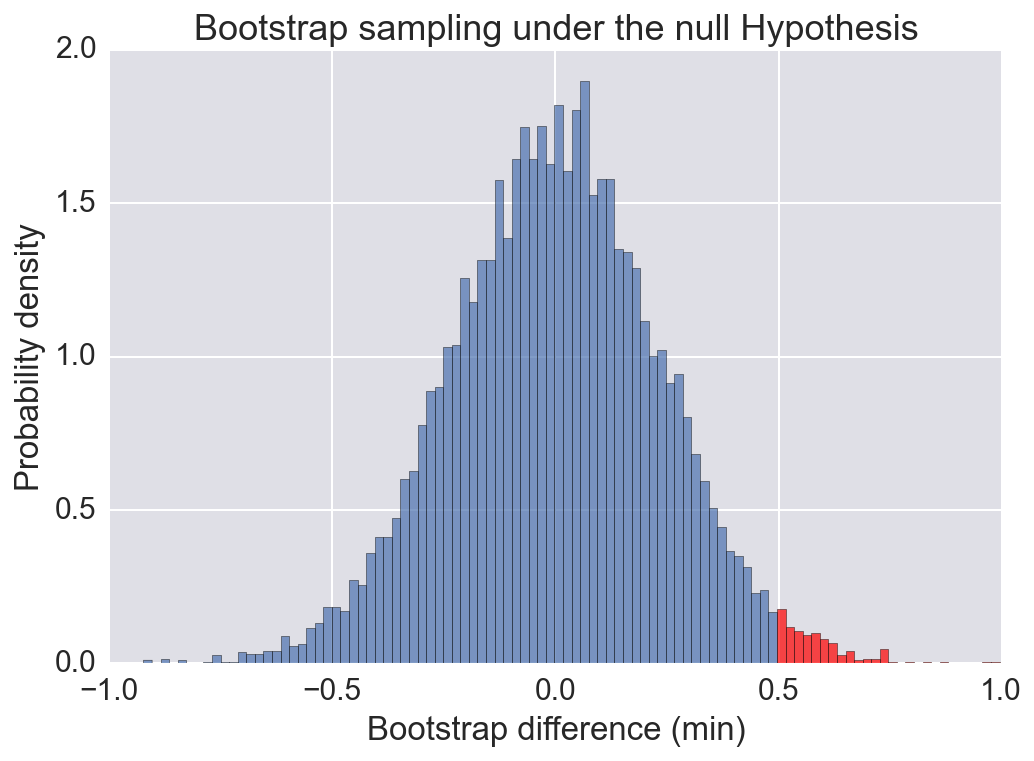

In [104]:
n, bins, patches = plt.hist(diffs, bins=100, normed=True, alpha=0.7)
for b, p in zip (bins, patches):
    if b < actual_diff:
        continue
    plt.setp(p, 'facecolor', 'red', alpha=0.7)
plt.xlabel ('Bootstrap difference (min)')
plt.ylabel ('Probability density')
plt.title ('Bootstrap sampling under the null Hypothesis')


# 5e
We already have the MAPs and covariance matrix from part c (H1), and it's called cov_1
Now we should calculate the MAPs and covariance matrix for H0

In [111]:
def log_post_0(p, x_0):
    """
    p[0] = mu_0
    p[1] = sigma_0
    """
    # Unpack parameters
    mu_0, sigma_0= p
    
    # Make sure we have everything in the right range
    if (sigma_0 < 0):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_0 = st.norm.logpdf(x_0, mu_0, sigma_0).sum() - np.log(sigma_0)

    # Add them up to return
    return log_post_0

In [52]:
rest = df['mean_rest_bout_length']
params = collections.OrderedDict([('mu_0', (np.random.uniform, (0, 5))),
                                  ('sigma_0', (np.random.exponential, (0.1,)))])

n_dim = 2        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 1000     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in


p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0,5, n_walkers)  
p0[:,1] = np.random.exponential(.1, n_walkers)    


sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_0, 
                                args=(rest,), threads=4)

In [53]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [54]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

In [55]:
# Get the index of the most probable parameter set

max_ind = np.argmax(sampler.flatlnprobability)

#sampler.flatlnprobability
# Pull out values.
mu_0_MAP, sigma_0_MAP= sampler.flatchain[max_ind,:]

# Print the results
print("""
Most probable parameter values:
Overall:   {0:.3f} +/- {1:.3f}
""".format(mu_0_MAP, sigma_0_MAP))


Most probable parameter values:
Overall:   1.938 +/- 0.711



In [56]:
cov_0 = np.cov(sampler.flatchain.T)

We now have the MAPs and covariance matrices for both models

Given that we want to calculate
\begin{align}
O_{01} = \frac{P(H_0\mid D, I)}{P(H_1\mid D, I)}.
\end{align}
Each piece, H0, and H1 can be expressed as
\begin{align}
P(H_i\mid D, I) = \frac{P(H_i\mid I) P(D\mid H_i, I)}{P(D\mid I)}.
\end{align}
This means that the odds ratio can be expressed as
\begin{align}
O_{01} = \frac{P(H_0\mid I) P(D\mid H_0, I)}{P(H_1\mid I) P(D\mid H_1, I)}.
\end{align}
Following the same simplifications used in Tutorial 5a,
\begin{align}
O_{01} = \frac{P(D\mid H_0, I)}{P(D\mid H_1, I)}.
\end{align}

This is just the ratio of the two likelihoods.
So now we need to calculate the likelihoods for H0 and H1

For a single parameter of repeated measurements, likelihood can be expressed as
\begin{align}
P(D \mid \mu, \sigma, I) = \prod_{i\in d} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(x_i - \mu)^2}{2\sigma^2}\right].
\end{align}

We can use this for all of our likelihoods, and just consider the likelihood of H1 as the product of two likelihoods, treating the wt and mut seperately.

In [122]:
#Likelihood function
def likelihood(dataset, mu, sigma):
    p = 1
    dataset_list = dataset.tolist()
    range_list = len(dataset_list)
    for q in range(range_list):
        p = p* ((1/np.sqrt(2*np.pi*(sigma**2)))\
                *np.exp(((-dataset_list[q]-mu)**2)/(2*(sigma**2))))
    return p

In [66]:
#mu_mut_MAP, , sigma_mut_MAP 
wt_likely = likelihood(wt_rest, mu_wt_MAP, sigma_wt_MAP)
mut_likely = likelihood(mut_rest, mu_mut_MAP, sigma_mut_MAP)


H0_likely = likelihood(rest, mu_0_MAP, sigma_0_MAP)

oddsratio = (H0_likely/wt_likely) /mut_likely

# the odds ratio for H0/H1 is
oddsratio

3.1778348282188058e-141

## Problem 5.1f

Let's begin by defining some functions that return the results given by each part. 

In [172]:
def part_b (first, second):
    """
    Uses bootstrapping to estimate the difference between the means of 
    two samples. 
    
    Returns: (p2.5, mean, p97.5), where px is the xth percentile
    """
    n1 = len (first)
    n2 = len (second)
    deltas = bootstrap_estimate (first, n1, np.mean, replicates=10000) \
    - bootstrap_estimate(second, n2, np.mean, replicates=10000)
    delta_bar = np.mean(deltas)
    CI = np.percentile (deltas, (2.5, 97.5))
    return (CI[0], delta_bar, CI[1])

@jit
def part_c (first, second):
    """
    Uses mcmc to get a Bayesian estimate of the difference between first_mean
    and second_mean
    """
    n_dim = 4        # number of parameters in the model
    n_walkers = 50   # number of MCMC walkers
    n_burn = 1000     # "burn-in" period to let chains stabilize
    n_steps = 5000   # number of MCMC steps to take after burn-in


    p0 = np.empty((n_walkers, n_dim))
    p0[:,0] = np.random.uniform(0,5, n_walkers)
    p0[:,1] = np.random.uniform(0,5, n_walkers)    
    p0[:,2] = np.random.exponential(.1, n_walkers)    
    p0[:,3] = np.random.exponential(.1, n_walkers) 


    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, 
                                    args=(first, second))
    # Do burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Sample again, starting from end burn-in state
    _ = sampler.run_mcmc(pos, n_steps)
    # Get the index of the most probable parameter set

    max_ind = np.argmax(sampler.flatlnprobability)

    #sampler.flatlnprobability
    # Pull out values.
    mu_wt_MAP, mu_mut_MAP, sigma_wt_MAP, sigma_mut_MAP = \
    sampler.flatchain[max_ind,:]
    delta_MAP = mu_wt_MAP - mu_mut_MAP
    sigma_delta_MAP = np.sqrt((sigma_wt_MAP**2)+(sigma_mut_MAP**2))
    return delta_MAP, sigma_delta_MAP
    
def part_d (first, second):
    """
    Do frequentist hypothesis testing on the H0: first and second are
    drawn from the same Gaussian distribution. 
    """
    
    combined = pd.concat([first, second])
    n1 = len(first)
    n2 = len(second)
    first_boot = bootstrap_estimate (combined, n1, np.mean, replicates=10000) 
    second_boot = bootstrap_estimate(combined, n2, np.mean, replicates=10000)
    diff = first_boot - second_boot
    actual_diff = first.mean() - second.mean()
    if actual_diff < 0:
        diff = -diff
        actual_diff = -actual_diff
    p_value = sum(d >= actual_diff for d in diffs)/len(diffs)
    return p_value

def part_e (first, second):
    """
    Compute the Bayesian odds ratio 
    """
    first_mean = first.mean()
    second_mean = second.mean()
    first_std = first.std()
    second_std = second.std()
    combined = pd.concat([first,second])
    combined_mean = combined.mean()
    combined_std = combined.std()
    first_likely = likelihood(first, first_mean, first_std)
    mut_likely = likelihood(second, second_mean, second_std)


    H0_likely = likelihood(combined, combined_mean, combined_std)

    odds_ratio = H0_likely / first_likely /mut_likely
    return odds_ratio

Now, let's draw 100 samples. 

In [168]:
n_samples = 100
samples = [(np.random.normal(x_bar_w, np.sqrt(var_w), n_wt), \
          np.random.normal(x_bar_m, np.sqrt(var_m), n_mut)) \
          for _ in range(n_samples)]

And now let's go through and calculate the results for each one. 

In [ ]:
bs = []
cs = []
ds = []
es = []
for s in samples:
    first = pd.Series(s[0])
    second = pd.Series(s[1])
    bs.append (part_b(first, second))
    cs.append (part_c(first, second))
    ds.append (part_d(first, second))
    es.append (part_e(first, second))

Plot all the frequentist confidence intervals for $\delta$

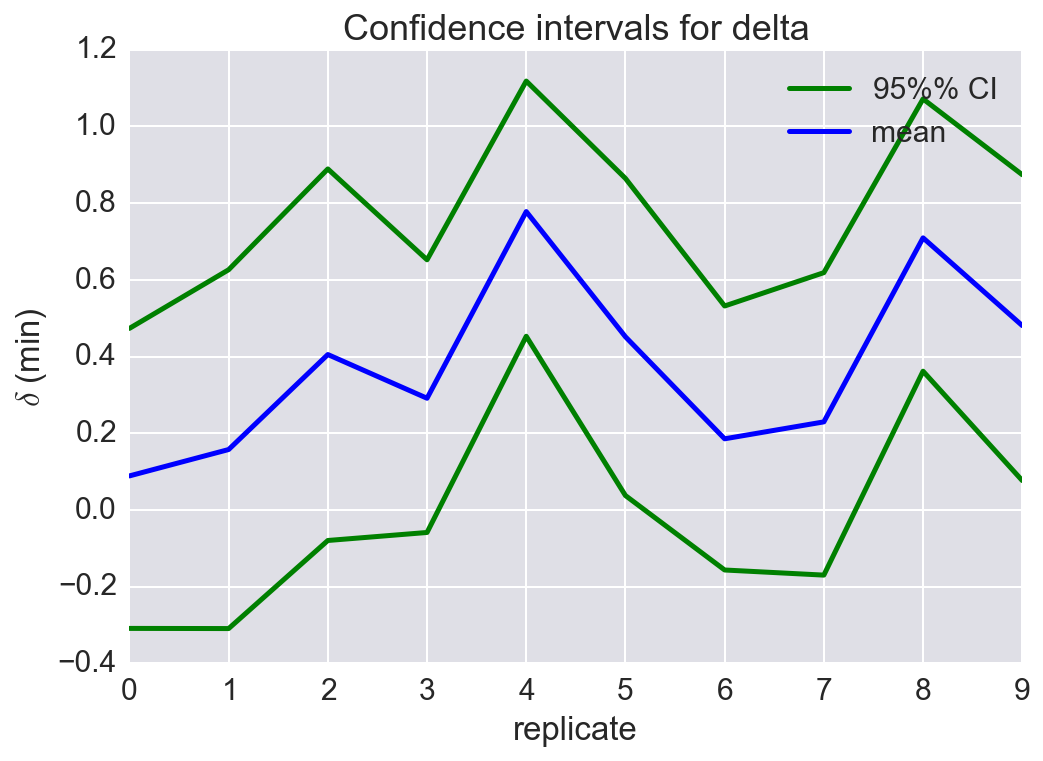

In [150]:
plt.plot([b[0] for b in bs], color='green')
plt.plot([b[1] for b in bs], color='blue')
plt.plot([b[2] for b in bs], color='green')
plt.xlabel ('replicate')
plt.ylabel ('$\delta$ (min)')
plt.legend (['95%% CI', 'mean'])
plt.title ('Confidence intervals for delta')

Plot the Bayesian credible regions for $\delta$

In [ ]:
plt.plot([c[0]+c[1] for c in cs], color='green')
plt.plot([c[0] for c in cs], color='blue')
plt.plot([b[0]-c[1] for c in cs], color='green')
plt.xlabel ('replicate')
plt.ylabel ('$\delta$ (min)')
plt.legend (['credible region', 'MAP'])
plt.title ('Credible regions for delta')

Plot the frequentist p-values

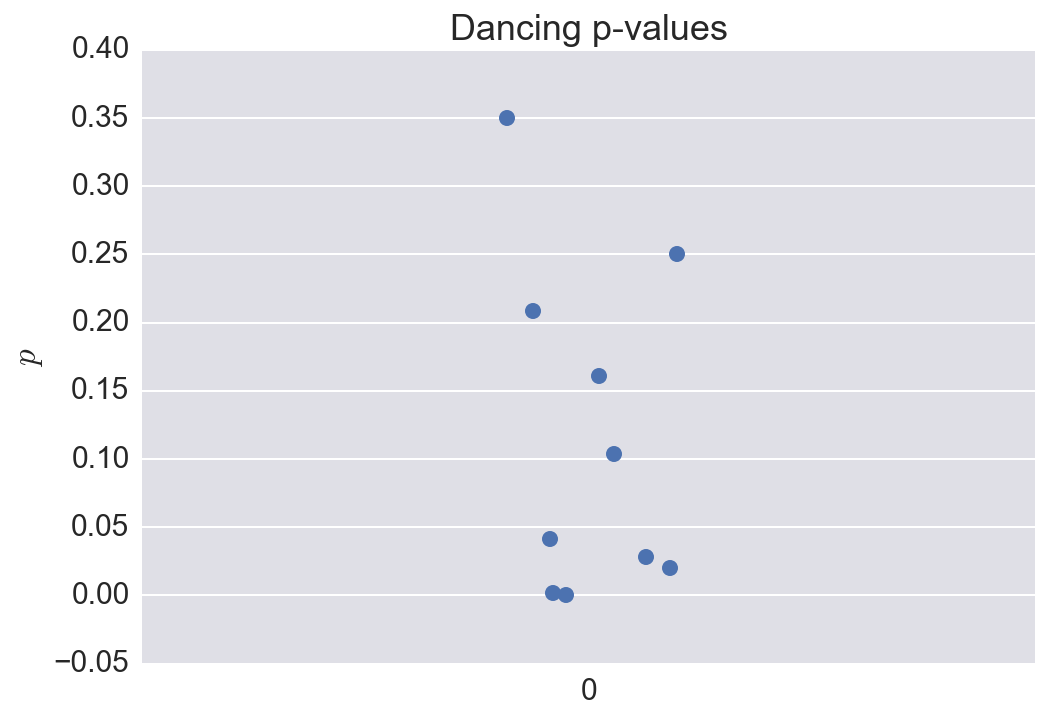

In [151]:
sns.stripplot(data=ds, jitter=True)
plt.title ('Dancing p-values')
plt.ylabel ('$p$')

Plot the Bayesian odds ratios. 

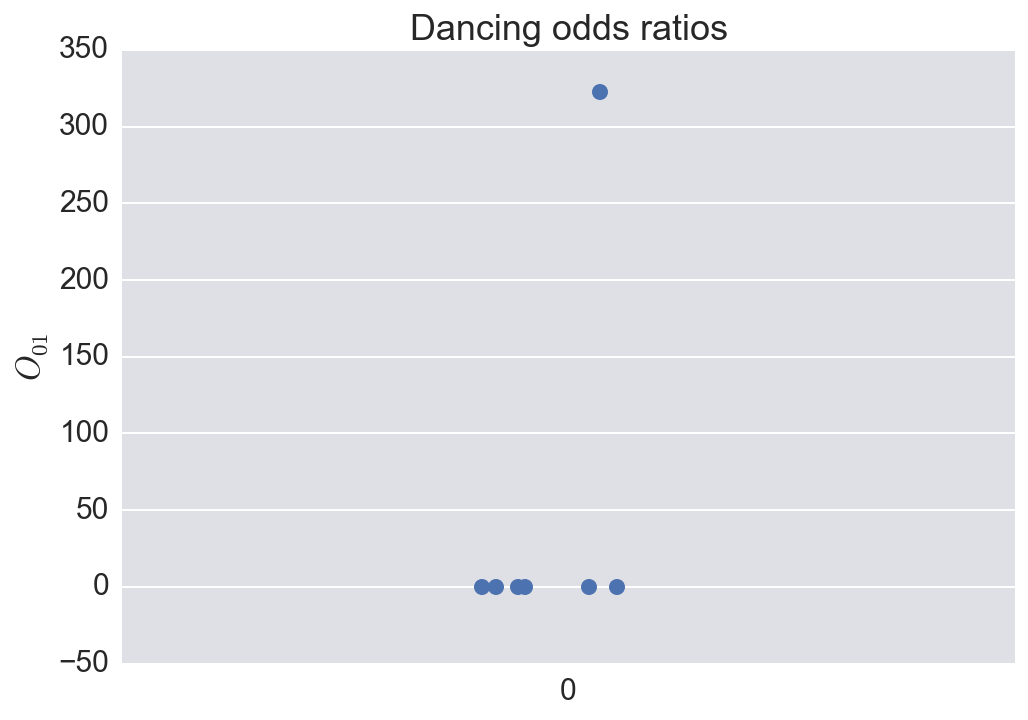

In [152]:
sns.stripplot(data=es, jitter=True)
plt.title ('Dancing odds ratios')
plt.ylabel ('$O_{01}$')

All of these values can vary a lot even while drawing from the same distributions. p-values especially are not very reproducible. 